In [ ]:
# Python version check
import sys
!{sys.executable} --version

In [28]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

Step 0. Glossary 
    - trx07 
    - trx08
    - trx09
    - upjong
    - cus

Step 1. Data Extraction 

In [29]:
# make sample

num_txn = 1000000 # 1/100 of real data 
num_cus = 40000 # 1/100 of real data
num_mct = 100 

In [30]:
array01old = np.random.randint(0, num_cus, size=(num_txn, 1) ) # CLNN

array01a = np.random.randn(num_txn, 1)
array01 = np.round(np.sqrt(np.square(array01a)) * 10000)
max(array01)

array([47459.])

In [31]:
array02 = np.random.randint(180701, 180731, size=(num_txn, 1)) # TS_D # 승인날짜

times = pd.date_range('2018-07-01', periods=31, freq='1440min')
array02new = np.random.choice(times, size=num_txn, replace=True, p=None)
array02new

array(['2018-07-31T00:00:00.000000000', '2018-07-30T00:00:00.000000000',
       '2018-07-12T00:00:00.000000000', ...,
       '2018-07-24T00:00:00.000000000', '2018-07-15T00:00:00.000000000',
       '2018-07-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [32]:
array03 = np.random.randint(0, 100, size=(num_txn, 1)) # FINAL_CD # 업종코드 

In [33]:
array04a = np.random.randn(num_txn, 1) # SAA # 승인금액
array04 = np.round(np.sqrt(np.square(array04a)) * 20 + 3) 

In [34]:
array05old = np.random.randint(0, 424, size=(num_txn, 1)) # MCT_ADM_GDS_APB_CD # 서울 행정동 코드

array05a = np.random.randn(num_txn, 1) 
array05 = np.round(np.sqrt(np.square(array05a)) * 30)

In [35]:
# array06a = np.random.randint(1, 2, size=(round(num_txn*5/7), 1)) # DOF_TF # 평일 or 휴일
# array06b = np.random.randint(0, 1, size=(round(num_txn*2/7), 1)) # DOF_TF # 평일 or 휴일
# array06 = np.append(array06a, array06b, axis=0)
# random.shuffle(array06)

In [36]:
# 더 간편한 방법
array06 = np.random.choice(2, size=num_txn, p=[5/7, 2/7]) # 2 미만의 정수 중 p의 확률로 랜덤 선택

In [37]:
array07 = np.random.randint(0, 6, size=(num_txn, 1)) # DAW_CCD # 요일코드 # array06과 맞추기 어려워서 임시로 랜덤

In [38]:
array08 = np.random.randint(0, num_mct, size=(num_txn, 1)) # MCT_N # 가맹점 번호

In [39]:
array09 = np.random.randint(1, 240000, size=(num_txn, 1)) # TIME # 24h 시간 # 정확히 맞는 숫자는 아님

In [40]:
df = pd.DataFrame( np.column_stack([array01, array02, array03, array04, array05, array06, array07, array08, array09])
                  , columns = ['CLNN', 'TS_D', 'FINAL_CD', 'SAA', 'MCT_ADM_GDS_APB_CD', 'DOF_TF', 'DAW_CCD', 'MCT_N', 'TIME'])

df.head(10)

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
0,5594.0,180724.0,8.0,19.0,38.0,0.0,3.0,95.0,100191.0
1,2590.0,180710.0,85.0,21.0,31.0,0.0,5.0,95.0,185134.0
2,24948.0,180708.0,27.0,5.0,3.0,0.0,2.0,75.0,151669.0
3,21388.0,180704.0,36.0,38.0,2.0,1.0,0.0,37.0,75808.0
4,10240.0,180730.0,67.0,26.0,15.0,1.0,0.0,74.0,215578.0
5,22150.0,180721.0,51.0,4.0,0.0,0.0,2.0,30.0,79068.0
6,1921.0,180701.0,50.0,8.0,1.0,0.0,0.0,66.0,213092.0
7,3666.0,180730.0,36.0,36.0,3.0,1.0,5.0,55.0,213061.0
8,11425.0,180729.0,56.0,24.0,4.0,0.0,3.0,2.0,190144.0
9,1011.0,180707.0,31.0,22.0,15.0,0.0,2.0,30.0,111389.0


### Data Merge 

In [18]:
df3 = df.append(df2, ignore_index=True) # sort 옵션?

In [20]:
df3.tail()

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
1999995,14648.0,180711.0,98.0,33.0,4.0,0.0,2.0,21.0,134269.0
1999996,21067.0,180718.0,75.0,29.0,86.0,1.0,0.0,66.0,16672.0
1999997,2834.0,180706.0,82.0,13.0,6.0,0.0,1.0,33.0,215536.0
1999998,6079.0,180701.0,61.0,4.0,1.0,1.0,2.0,99.0,46073.0
1999999,7628.0,180714.0,67.0,26.0,13.0,0.0,4.0,56.0,222749.0


In [14]:
trx07_08_df = trx07_df.append(trx08_df, ignore_index=True, \
                           sort=True) #sort=sort 옵션

NameError: name 'trx07_df' is not defined

In [ ]:
trx07_08_09_df = trx07_08_df.append(trx09_df, ignore_index=True, \
                           sort=True) #sort=sort 옵션

### GroupBy 객체 만들기

In [22]:
groupedByCLNN = df.groupby('CLNN')

In [23]:
groupedByCLNN.describe()['SAA'].head() # 계산시 오래걸림

,count,mean,std,min,25%,50%,75%,max
CLNN,,,,,,,,
0.0,38.0,19.605263,12.264075,3.0,8.75,17.5,29.50,44.0
1.0,84.0,19.047619,10.529253,3.0,10.00,17.0,26.25,47.0
2.0,93.0,18.000000,12.003623,3.0,8.00,15.0,25.00,51.0
3.0,80.0,20.412500,13.758030,3.0,9.00,19.0,28.00,63.0
4.0,70.0,20.057143,13.842683,3.0,9.00,15.5,26.75,58.0


In [174]:
groupedByCLNN.count()['SAA'].head()

CLNN
0.0    46
1.0    80
2.0    81
3.0    82
4.0    85
Name: SAA, dtype: int64

In [175]:
groupedByCLNN.sum()['SAA'].head()

CLNN
0.0     954.0
1.0    1417.0
2.0    1458.0
3.0    1453.0
4.0    1598.0
Name: SAA, dtype: float64

In [176]:
groupedByCLNN.mean()['SAA'].head()

CLNN
0.0    20.739130
1.0    17.712500
2.0    18.000000
3.0    17.719512
4.0    18.800000
Name: SAA, dtype: float64

In [177]:
# 2개 기준으로 Group By 하기
gb = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD']) # 고객별 & 행정동별
gb2 = gb.sum()['SAA'] # 금액 합
gb2

CLNN     MCT_ADM_GDS_APB_CD
0.0      6.0                   11.0
         16.0                   6.0
         17.0                  28.0
         18.0                  49.0
         21.0                  33.0
         22.0                  12.0
         23.0                  40.0
         24.0                  31.0
         25.0                  39.0
         27.0                  77.0
         28.0                  22.0
         29.0                  79.0
         31.0                  68.0
         32.0                  14.0
         33.0                  55.0
         34.0                   6.0
         41.0                  60.0
         42.0                  34.0
         43.0                  11.0
         45.0                  11.0
         46.0                  22.0
         47.0                  30.0
         49.0                   4.0
         53.0                  36.0
         60.0                  25.0
         65.0                  15.0
         72.0                  18.0


In [178]:
# 2개 기준으로 Group By 하기
gb3 = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD']).sum()['SAA'] # 고객별 & 행정동별 합 chaining
gb3

CLNN     MCT_ADM_GDS_APB_CD
0.0      6.0                   11.0
         16.0                   6.0
         17.0                  28.0
         18.0                  49.0
         21.0                  33.0
         22.0                  12.0
         23.0                  40.0
         24.0                  31.0
         25.0                  39.0
         27.0                  77.0
         28.0                  22.0
         29.0                  79.0
         31.0                  68.0
         32.0                  14.0
         33.0                  55.0
         34.0                   6.0
         41.0                  60.0
         42.0                  34.0
         43.0                  11.0
         45.0                  11.0
         46.0                  22.0
         47.0                  30.0
         49.0                   4.0
         53.0                  36.0
         60.0                  25.0
         65.0                  15.0
         72.0                  18.0


In [182]:
df.sort_values(['MCT_ADM_GDS_APB_CD', 'SAA'], ascending=False).groupby(['CLNN']).head() ## 예시 ## TS_D와 FINAL_CD는 aggregate 되지 않았음 

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
643724,16993.0,180726.0,41.0,27.0,355.0,0.0,0.0,97.0,135335.0
245942,1185.0,180730.0,96.0,26.0,354.0,1.0,1.0,85.0,132441.0
208852,4725.0,180715.0,84.0,28.0,345.0,0.0,1.0,66.0,5820.0
717839,7155.0,180702.0,64.0,12.0,345.0,1.0,5.0,15.0,189679.0
349446,16661.0,180727.0,58.0,6.0,334.0,0.0,2.0,21.0,208891.0
709605,2307.0,180702.0,61.0,35.0,330.0,0.0,2.0,26.0,67692.0
544604,15646.0,180725.0,79.0,5.0,316.0,0.0,3.0,44.0,104994.0
393677,7695.0,180708.0,3.0,14.0,313.0,0.0,4.0,10.0,27388.0
401154,12838.0,180703.0,55.0,18.0,310.0,0.0,3.0,44.0,111285.0
601656,10519.0,180708.0,58.0,21.0,307.0,0.0,4.0,42.0,228212.0


In [185]:
# 고객당 평균 몇 개의 동에서 거래가 이루어졌는가?
grouped = df.groupby(['CLNN'], sort=False).count()['MCT_ADM_GDS_APB_CD']
print(grouped.head(15))
print(np.mean(grouped[:2]) )

CLNN
9837.0     52
8631.0     45
2531.0     86
5663.0     71
7783.0     66
191.0      74
821.0      71
8145.0     59
3278.0     68
14187.0    26
3707.0     74
4650.0     91
9585.0     61
8571.0     57
9170.0     60
Name: MCT_ADM_GDS_APB_CD, dtype: int64
54.19524804751953


### df를 sort하기

In [186]:
df.sort_values(by=['MCT_ADM_GDS_APB_CD', 'TIME'], ascending=True).head()

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
602092,19985.0,180712.0,88.0,22.0,0.0,0.0,5.0,91.0,18.0
649470,8914.0,180723.0,38.0,16.0,0.0,0.0,1.0,9.0,47.0
911259,2511.0,180707.0,53.0,44.0,0.0,0.0,4.0,3.0,80.0
380544,288.0,180713.0,96.0,38.0,0.0,0.0,0.0,27.0,85.0
438088,1593.0,180729.0,93.0,47.0,0.0,1.0,5.0,54.0,140.0


### GroupBy 객체를 sorting 하기

In [188]:
grouped = df.groupby(['CLNN'], sort=False).sum() # 여기에서 sort=False 가 중요한 것 같음
grouped.sort_values('SAA', ascending=False)['SAA']  

CLNN
1429.0     2395.0
1310.0     2265.0
2288.0     2224.0
1181.0     2215.0
61.0       2199.0
633.0      2197.0
499.0      2178.0
3008.0     2157.0
2191.0     2124.0
517.0      2110.0
1875.0     2108.0
629.0      2093.0
4892.0     2085.0
2089.0     2084.0
1496.0     2078.0
2147.0     2076.0
1486.0     2071.0
892.0      2065.0
582.0      2058.0
765.0      2053.0
3992.0     2053.0
740.0      2047.0
809.0      2046.0
288.0      2037.0
1013.0     2037.0
497.0      2006.0
2109.0     2005.0
15.0       2002.0
1077.0     1996.0
1373.0     1994.0
            ...  
27803.0       3.0
25893.0       3.0
33069.0       3.0
26775.0       3.0
28345.0       3.0
25193.0       3.0
27212.0       3.0
38607.0       3.0
29240.0       3.0
31011.0       3.0
24959.0       3.0
27235.0       3.0
31458.0       3.0
40288.0       3.0
44074.0       3.0
33343.0       3.0
26854.0       3.0
25104.0       3.0
23492.0       3.0
25860.0       3.0
34295.0       3.0
34917.0       3.0
31731.0       3.0
33882.0       3.0
29269

In [190]:
grouped = df.groupby(['MCT_ADM_GDS_APB_CD'], sort=False).sum()  
grouped.sort_values('SAA', ascending=False)['SAA']  

MCT_ADM_GDS_APB_CD
4.0      217492.0
6.0      215742.0
8.0      214608.0
13.0     214252.0
3.0      214054.0
5.0      213921.0
11.0     213622.0
7.0      213365.0
9.0      213289.0
15.0     212370.0
2.0      212266.0
1.0      212210.0
12.0     212147.0
18.0     211983.0
17.0     211868.0
16.0     211253.0
10.0     210984.0
14.0     209861.0
19.0     208064.0
22.0     207602.0
20.0     207414.0
21.0     205396.0
25.0     204098.0
24.0     204054.0
23.0     202750.0
28.0     200711.0
27.0     199492.0
32.0     198925.0
26.0     197211.0
29.0     196708.0
           ...   
296.0        58.0
287.0        54.0
291.0        51.0
292.0        51.0
301.0        46.0
345.0        40.0
290.0        38.0
288.0        38.0
298.0        36.0
304.0        35.0
330.0        35.0
289.0        32.0
283.0        32.0
271.0        31.0
286.0        29.0
307.0        28.0
355.0        27.0
294.0        27.0
293.0        26.0
354.0        26.0
295.0        23.0
310.0        18.0
299.0        17.0
313.0    

In [187]:
grouped = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD'], sort=False).sum() # 여기에서 sort=False 가 중요한 것 같음
grouped.sort_values('SAA', ascending=False)['SAA'] # multiple 기준으로 sorting은 안되는듯 

CLNN     MCT_ADM_GDS_APB_CD
1748.0   24.0                  192.0
4808.0   32.0                  189.0
1370.0   54.0                  182.0
12837.0  70.0                  179.0
2375.0   44.0                  179.0
3081.0   20.0                  173.0
787.0    2.0                   173.0
4714.0   39.0                  172.0
5238.0   27.0                  171.0
4390.0   18.0                  171.0
2466.0   54.0                  169.0
9033.0   15.0                  168.0
2037.0   62.0                  167.0
753.0    15.0                  165.0
4706.0   19.0                  164.0
474.0    64.0                  164.0
1392.0   45.0                  164.0
3932.0   3.0                   164.0
4965.0   32.0                  163.0
3894.0   15.0                  163.0
49.0     52.0                  163.0
9494.0   6.0                   163.0
2527.0   23.0                  162.0
5147.0   33.0                  161.0
6531.0   16.0                  160.0
3011.0   6.0                   160.0
1385.0   4

In [ ]:
grouped.sort_values('CLNN', ascending=True) # NOT WORKING !! 처음 group by 한 원래 기준으로 sorting도 안되는듯

In [ ]:
gb2.apply(lambda _df: _df.sort_values(by=['SAA']))

In [ ]:
df.pivot('MCT_ADM_GDS_APB_CD', 'FINAL_CD', 'CLNN')

### 조건에 맞는 일부 원소만 추출하기

In [ ]:
df = df[df.Volume !=0]

### Cross-sectional / Aggregate 분석

#### 히스토그램 

In [ ]:
df['SAA'].hist(bins=70)

In [ ]:
df['person'].value_counts() 

value_counts 함수를 이용해 자동으로 그루핑되어 sum up된 결과물을 볼 수 있다.

In [ ]:
분포

### 시계열 분석 

1. 7월 1일부터 9월 30일까지의 총 매출 건수 추이 -- 원래 YoY, MoM 들어가야 하지만...
2. 7월 1일부터 9월 30일까지의 총 매출 금액 추이
3. 7월 1일부터 9월 30일까지의 매출 건수/인 추이
4. 7월 1일부터 9월 30일까지의 매출 금액/인 추이
5. 7월 1일부터 9월 30일까지의 행정동 개수/인 추이 -- mobility 의 지표, 향후 거리 개념이 도입되면 평균 이동거리를 알 수 있음 
6. ....

### 공간 시계열 분석

 (매출 상위 100개 행정동)

log('SAA')

20-
15-
10-
05-
00- ----------------------------
    z0 z1 z3 z4 ....................
    
zone 별 매출 share가 이미 다르다 --> 상권의 비동질성
집중도.......
주식시장, 자산시장, 

시간대별 매출 분포 -- 이건 지역별로 너무 다를 듯

log('SAA')

20-
15-
10-
05-
00- ---------------------
    00 04 08 12 16 20 24 

In [ ]:
인별 점찍기....

시간
24-
20-
16-
12-
08-
04-
00- ----------------------------
    z0 z1 z3 z4 ....................

In [ ]:
인별 feature -- 거래건의 최신성이나 금액에 있어 가중치는 0

시간: round('TIME'/240000) -- 아침러 vs 저녁러 -- 소비시간 score ..... 0시는 삭제하거나 하루의 시작을 +6 으로 하거나
요일: 
장소: 평균 19개 --> len(['FINAL_CD'])/19 
업종

시간 집중도
장소 집중도
업종 집중도

### 문자열을 숫자로 type 바꾸기

http://m.dbguide.net/about.db?cmd=view&boardConfigUid=19&boardUid=188976

In [ ]:
levels = []
for level in deck:
    levels.append(level[0])

첫 번째 글자만 가져와서 새로운 객체에 담아보자. 
새로운 리스트 객체 levels에 앞 글자 하나만 가져와서 담은 후에 이를 아래와 같이 DataFrame으로 만들어보자.

In [ ]:
cabin_df = DataFrame(levels)
cabin_df.columns = ['Cabin']
cabin_df.head()

T라는 Deck는 없는데 그래프에는 T라는 데이터가 있다는 것이다. T라는 Deck만 빼고 다시 가져와야 한다.

In [ ]:
cabin_df = cabin_df[cabin_df.Cabin != 'T']
sns.factorplot('Cabin', kind='count', data=cabin_df, palette='summer')

DataFrame인 titanic_df의 각 컬럼에 접근하는 것의 기준은 점(.)이다. 
Survived 컬럼에서 map이라는 함수를 이용해 특정 정보일 경우, 특정 값으로 매핑을 해준 것이다. 

In [ ]:
titanic_df["Survivor"] = titanic_df.Survived.map({0: "no", 1: "yes"})

DataFrame인 titanic_df의 각 컬럼에 접근하는 것의 기준은 점(.)이다. 
xSurvived 컬럼에서 map이라는 함수를 이용해 특정 정보일 경우, 특정 값으로 매핑을 해준 것이다. 

DataFrame인 titanic_df의 각 컬럼에 접근하는 것의 기준은 점(.)이다. 
Survived 컬럼에서 map이라는 함수를 이용해 특정 정보일 경우, 특정 값으로 매핑을 해준 것이다. 

### 시간정보를 파싱하기

문자열로부터 날짜와 시간 정보를 읽어서 datetime.datetime 클래스 객체를 만들 수도 있다. 이 때는 datetime.datetime.strptime() 클래스 메서드를 사용한다. 첫 번째 인수로는 날짜와 시간 정보를 가진 문자열을, 두번째 인수로는 그 문자열을 해독할 수 있는 형식 문자열을 넣는다.

In [164]:
datetime.datetime.strptime("2017-01-02 14:44", "%Y-%m-%d %H:%M")

datetime.datetime(2017, 1, 2, 14, 44)

In [166]:
datetime.datetime.strptime("144401", "%H%M%S")

datetime.datetime(1900, 1, 1, 14, 44, 1)

*이슈사항 1: Resolve type problem*

In [3]:
datetime.datetime.strptime(trx_df['TIME'], "%H%M%S")
# gets Warning Message: triptime() arguement 1 must be str, not Series*.

NameError: name 'datetime' is not defined

In [25]:
# 이슈사항 2: ==> resolved

In [26]:
# 이슈사항 3: is null을 물었을 때 True의 개수 확인* ==> resolved

In [6]:
# 숫자로 바꿀 수 없는 문자열이 있는지 확인 => resolved

In [27]:
# 이슈사항4: df를 합칠 때 컬럼이 다른 경우 => resolved*

In [ ]:
df.info()
df.index

*이슈사항5: 시간을 불러와서 시간별로 합치거나, 시간의 계산을 하려고 한다*

http://enjoyiot.tistory.com/category/Python/04_Pandas%EB%A5%BC%20%ED%86%B5%ED%95%9C%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%28Time%20Series%29%20%EC%B2%98%EB%A6%AC

In [ ]:
df = pd.read_csv('file.csv', index_col='Date', parse_dates=True)

In [ ]:
# 그 전에 인덱스를 날짜로 바꾸어 주어야 함
df.set_index('Date', inplace=False)

df.resample(rule='A') # rule='A'는 1년에 한번, Q는 분기.. 매뉴얼을 보자
df.resample(rule='A').mean() # 1년동안의 평균 값을 제공
df.resample(rule='A').max() # 1년동안의 평균 값을 제공

In [ ]:
# customized function

def first_day(entry):
    return entry[0]

df.resample('A').apply(first_day)

In [ ]:
# 각 close에 대해 매년 평균 구하고 bar 차트를 그려라
df['Close'].resample('A').mean().plot(kind='bar') 
df['Close'].resample('M').mean().plot(kind='bar', figsize=(16, 6))

DateTime Index
Time Resampling
Time Shifts
Rolling and Expanding

dataframe의 행 또는 열 삭제하기

In [ ]:
# 열 삭제
df = df.drop('col_name', 1) # 여기서 1은 축 번호, 행은 0, 열은 1

# 혹은 df를 재할당하지 않고 열 삭제
df.drop('col_name', axis=1, inplace=True)

# 열 레이블 대신 열 번호를 사용하여 삭제
df.drop(df.columns[[0, 1, 3]], axis=1)

### 다른 df로부터 정보 추출하여 매칭하기

In [ ]:
# upjong

num_upjong = 2786049
upjong = pd.DataFrame(np.random.randint(0, 100, size=(num_upjong, 3)))
upjong.columns = ['MCT_N', 'FINAL_CD', 'FINAL_CD_NM']
upjong.head()

In [ ]:
grouped = upjong.groupby('MCT_N')

In [ ]:
grouped.head()

In [ ]:
grouped.count().head()

In [9]:
grouped.describe()['SAA'].head()

NameError: name 'grouped' is not defined

In [ ]:
# file read in memory 
# takes a long time so beware session failure
trx07 = pd.read_csv('') 

In [ ]:
# file read in memory 
# takes a long time so beware session failure
trx08 = pd.read_csv('')

In [ ]:
# file read in memory 
# takes a long time so beware session failure
trx09 = pd.read_csv('') 

In [ ]:
# check if data is succesfully loaded in memory
# count rows


In [ ]:
# check data


Step 2. Data Wrangling

In [ ]:
# count trx, group by dong

# Make GroupBy object
groupByDong = trx07.groupby('dong')

In [ ]:
groupedByDong.count()
groupedByDong.sum()

만약 특정 변수에 대해서만 그룹별 요약/집계를 하고 싶다면 해당 변수를 indexing해주면 되며, 한개 변수에 대해서만 GroupBy 집계를 하면 반환되는 결과는 Series가 됩니다. 한개 변수에 대해 GroupBy 집계해서 나온 Series를 DataFrame으로 만들고 싶으면 pd.DataFrame() 를 사용해서 집계 결과를 DataFrame으로 변환해주면 됩니다. 

In [ ]:
groupedByDong.sum()['amount'] # Series

pd.DataFrame(groupedByDong.sum()['amount']) # DataFrame 

In [ ]:
groupedByDong.describe()['amount']

필요로 하는 집계함수가 pandas GroupBy methods에 없는 경우 사용자 정의 함수를 정의해서 집계에 사용할 수 있습니다. IQR(Inter-Quartile Range, Q3 - Q1) 를 사용자 정의 함수로 정의하고, 이를 grouped.aggregate() 혹은 grouped.agg() 의 괄호 안에 넣어서 그룹 별로 IQR를 계산해보겠습니다. 

In [ ]:
def iqr_func(x):

    q3, q1 = np.percentile(x, [75, 25])

    iqr = q3 - q1

    return iqr

In [ ]:
groupedByDong.agg(iqr_func) # groupedByDong.aggregate(iqr_func) 도 같은 결과

#### 기 과제

In [24]:
아웃풋이미지

(1) 위치
CLNN--WEEK OF DAY--SEX_CCD--AGE_GB--POISITION--FINAL_CD_NM--PSN_CL_HGA--PSN_DAY_COUNT--RTO_CL_CNT--RNK_POSITION--RANK_UPJONG
P24602--주중평일 혹은 토요일 등--F--61세이상--강남역--요식--57000--2--2--50--50--1--1

(2) 시간
CLNN--DAYS--TIMES--SEX_CCD--AGE_GB--FINAL_CD_NM--PSN_CL_HGA--PSN_DAY_COUNT--RTO_CL_CNT--RTO_CAY_CNT--RNK_TIME
--RANK_UPJONG
P9532--주중평일--오후--F--25세이하--편의점--25400--12--11--66.67--64.71--1--1

SyntaxError: invalid syntax (<ipython-input-24-3e289dcf200f>, line 2)

In [ ]:
# 이슈: 매출테이블에서 MCT_ADM_GDS_APB_CD(행정동)와 TIME(시간) 을 뽑아서, tuple 의 list 로 만들기 (클러스터링용)

In [ ]:
cus_id = 0
trx_df_9999999332 = df[df.CLNN == 0]

In [68]:
X1 = trx_df_9999999332['TIME']
X2 = trx_df_9999999332['MCT_ADM_GDS_APB_CD']

In [69]:
df['MCT_ADM_GDS_APB_CD'] = pd.to_numeric(df['MCT_ADM_GDS_APB_CD'], errors='coerce')
df.dropna()

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
0,5594.0,180724.0,8.0,19.0,38.0,0.0,3.0,95.0,100191.0
1,2590.0,180710.0,85.0,21.0,31.0,0.0,5.0,95.0,185134.0
2,24948.0,180708.0,27.0,5.0,3.0,0.0,2.0,75.0,151669.0
3,21388.0,180704.0,36.0,38.0,2.0,1.0,0.0,37.0,75808.0
4,10240.0,180730.0,67.0,26.0,15.0,1.0,0.0,74.0,215578.0
5,22150.0,180721.0,51.0,4.0,0.0,0.0,2.0,30.0,79068.0
6,1921.0,180701.0,50.0,8.0,1.0,0.0,0.0,66.0,213092.0
7,3666.0,180730.0,36.0,36.0,3.0,1.0,5.0,55.0,213061.0
8,11425.0,180729.0,56.0,24.0,4.0,0.0,3.0,2.0,190144.0
9,1011.0,180707.0,31.0,22.0,15.0,0.0,2.0,30.0,111389.0


In [67]:
cus_id = 'P9999999332'
trx_df_9999999332 = trx_df[trx_df.CLNN == cus_id]

X1 = trx_df_9999999332['TIME']
X2 = trx_df_9999999332['MCT_ADM_GDS_APB_CD']

trx_df['MCT_ADM_GDS_APB_CD'] = pd.to_numeric(trx_df['MCT_ADM_GDS_APB_CD'], errors='coerce')
trx_df.dropna()

NameError: name 'trx_df' is not defined

In [105]:
X1 = list(zip(trx_df_9999999332.TIME/10000, trx_df_9999999332.MCT_ADM_GDS_APB_CD ))
X_round = list(zip(round(trx_df_9999999332.TIME/10000), round(trx_df_9999999332.MCT_ADM_GDS_APB_CD) ))

In [106]:
X1 = np.array(X)
X_round = np.array(X_round)

In [107]:
print(X1[:, 0])
print(X1[:, 1])

[21.891   2.7063 16.0045  8.9271 16.4363  1.0395 13.9973  0.4724 16.9214
  9.6033 19.8156  9.9267 18.679  12.8312 18.7204  1.3644 23.7867  4.4964
 19.3659 13.755   6.9715  9.4499 15.0505 10.6363 18.9239 22.4845 10.0918
  0.0534 17.9695 11.5775 22.6419  6.4548  2.075   7.539  20.5871 19.8891
 20.0384  4.0601]
[13.  9. 50. 30. 41.  6. 14.  6. 19. 10. 42. 47. 29. 22. 12. 52. 10. 55.
 25. 17. 46. 20. 13. 83. 15.  9. 37. 56. 39. 15.  2. 34. 12. 35. 21. 38.
 39. 34.]


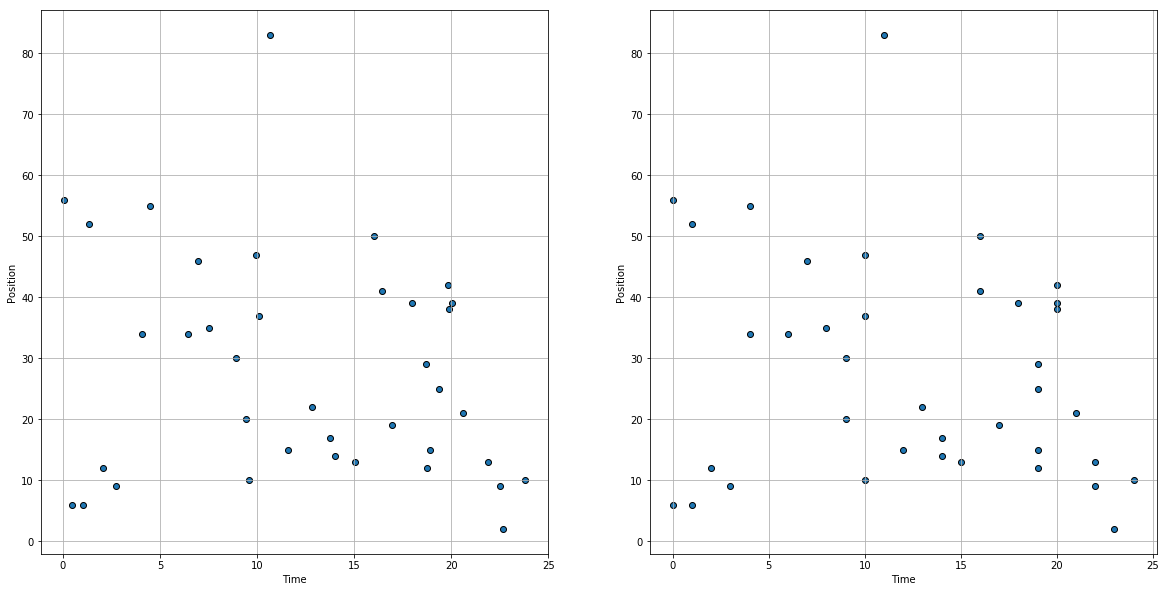

In [108]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.scatter(X1[:, 0], X1[:, 1], edgecolors='black')
plt.xlabel("Time"); plt.ylabel("Position")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(X_round[:, 0], X_round[:, 1], edgecolors='black')
plt.xlabel("Time"); plt.ylabel("Position")
plt.grid()

In [109]:
X.dtype

dtype('float64')

In [121]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X1_st=scaler.fit_transform(X1)

In [112]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X1_mm=scaler.fit_transform(X1)
# X2_mm=scaler.fit_transform(X2)

In [113]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
X1_norm=scaler.fit_transform(X1)
# X2_norm=scaler.fit_transform(X2)

In [114]:
from sklearn.cluster import KMeans

NameError: name 'kmeans3st' is not defined

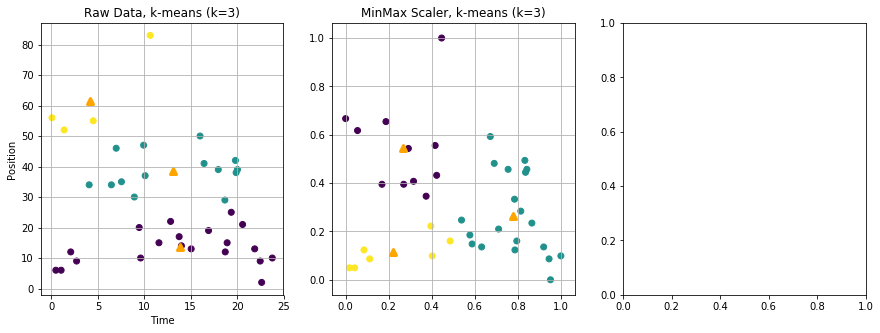

In [122]:
kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(X1)
assignments3 = kmeans3.labels_

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans3.labels_)
plt.scatter(kmeans3.cluster_centers_[:, 0], kmeans3.cluster_centers_[:, 1], marker='^', linewidth=3, c='orange')
plt.xlabel("Time"); plt.ylabel("Position")
plt.grid()
plt.title("Raw Data, k-means (k=3)")

kmeans3mm = KMeans(n_clusters=3)
kmeans3mm.fit(X1_mm)
assignments3mm = kmeans3mm.labels_

plt.subplot(1, 4, 2)
plt.scatter(X1_mm[:, 0], X1_mm[:, 1], c=kmeans3mm.labels_)
plt.scatter(kmeans3mm.cluster_centers_[:, 0], kmeans3mm.cluster_centers_[:, 1], marker='^', linewidth=3, c='orange')
plt.grid()
plt.title("MinMax Scaler, k-means (k=3)")

kmeans3norm = KMeans(n_clusters=3)
kmeans3norm.fit(X1_norm)
assignments3norm = kmeans3norm.labels_
 
plt.subplot(1, 4, 3)
plt.scatter(X1_st[:, 0], X1_st[:, 1], c=kmeans3st.labels_)
plt.scatter(kmeans3st.cluster_centers_[:, 0], kmeans3st.cluster_centers_[:, 1], marker='^', linewidth=3, c='orange')
plt.grid()
plt.title("Standard Scaler, k-means (k=3)")
 
kmeans3st = KMeans(n_clusters=3)
kmeans3st.fit(X1_st)
assignments3st = kmeans3st.labels_

plt.subplot(1, 4, 4)
plt.scatter(X1_norm[:, 0], X1_norm[:, 1], c=kmeans3norm.labels_)
plt.scatter(kmeans3norm.cluster_centers_[:, 0], kmeans3norm.cluster_centers_[:, 1], marker='^', linewidth=3, c='orange')
plt.grid()
plt.title("Normalizer, k-means (k=3)")

plt.show()

In [123]:
from sklearn.cluster import AgglomerativeClustering

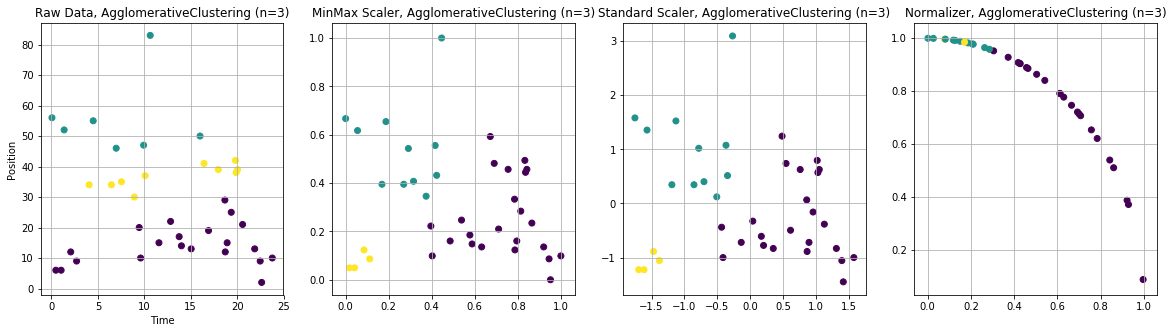

In [124]:
#
agg3 = AgglomerativeClustering(n_clusters=3)
agg3.fit(X1)
assignments = agg3.labels_

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(X1[:, 0], X1[:, 1], c=agg3.labels_) 
plt.xlabel("Time"); plt.ylabel("Position")
plt.grid()
plt.title("Raw Data, AgglomerativeClustering (n=3)")

#
agg3mm = AgglomerativeClustering(n_clusters=3)
agg3mm.fit(X1_mm)
assignments3mm = agg3mm.labels_

plt.subplot(1, 4, 2)
plt.scatter(X1_mm[:, 0], X1_mm[:, 1], c=agg3mm.labels_) 
plt.grid()
plt.title("MinMax Scaler, AgglomerativeClustering (n=3)")

#
agg3st = AgglomerativeClustering(n_clusters=3)
agg3st.fit(X1_st)
assignments3st = agg3st.labels_
 
plt.subplot(1, 4, 3)
plt.scatter(X1_st[:, 0], X1_st[:, 1], c=agg3st.labels_) 
plt.grid()
plt.title("Standard Scaler, AgglomerativeClustering (n=3)")
 
#
agg3norm = AgglomerativeClustering(n_clusters=3)
agg3norm.fit(X1_st)
assignments3norm = agg3norm.labels_

plt.subplot(1, 4, 4)
plt.scatter(X1_norm[:, 0], X1_norm[:, 1], c=agg3norm.labels_) 
plt.grid()
plt.title("Normalizer, AgglomerativeClustering (n=3)")

plt.show()